## **Information.**

**<span style="color:red">Task:</span>** to forecast the electricity demands of two American cities. 


**Columns:**
* date – date between 7 May 1996 to 5 December 1998. Here normalized between 0 and 1;
* day – day of the week (1-7);
* period – time of the measurement (1-48) in half hour intervals over 24 hours (normalized between 0 and 1);
* nswprice – New South Wales electricity price (normalized between 0 and 1);
* nswdemand – New South Wales electricity demand (normalized between 0 and 1);
* vicprice – Victoria electricity price (normalized between 0 and 1);
* vicdemand – Victoria electricity demand (normalized between 0 and 1);
* transfer – scheduled electricity transfer between both states (normalized between 0 and 1);
* class – the change of the price (up or down) in New South Wales relative to a moving average of the last 24 hours (and removes the impact of longer term price trends).

Each example of the dataset refers to a period of 30 minutes, i.e. there are 48 instances for each time period of one day. Each example on the dataset has 5 fields, the day of week, the time stamp, the New South Wales electricity demand, the Victoria electricity demand, the scheduled electricity transfer between states and the class label.

## **Necessary libraries.**

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import missingno as msno
from sklearn.metrics import roc_curve, auc
import joblib
import os

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/electricity.csv


## **Dataset downloading.**

In [3]:
df = pd.read_csv("/kaggle/input/electricity.csv")

## **Analysis and Data Preparation.**

Change column name in order to solve possible problems with visualization. 

In [4]:
df = df.rename(columns={'class': 'classs'})

In [5]:
df.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,classs
0,0.0,b'2',0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,b'UP'
1,0.0,b'2',0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,b'UP'
2,0.0,b'2',0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,b'UP'
3,0.0,b'2',0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,b'UP'
4,0.0,b'2',0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,b'DOWN'


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45312 entries, 0 to 45311
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       45312 non-null  float64
 1   day        45312 non-null  object 
 2   period     45312 non-null  float64
 3   nswprice   45312 non-null  float64
 4   nswdemand  45312 non-null  float64
 5   vicprice   45312 non-null  float64
 6   vicdemand  45312 non-null  float64
 7   transfer   45312 non-null  float64
 8   classs     45312 non-null  object 
dtypes: float64(7), object(2)
memory usage: 3.1+ MB


The dataset has 7 decimal columns and 2 string columns, 9 columns in total.

In [7]:
df_len = len(df) 
df_len

45312

The length of the dataset is 45,312.

In [8]:
df.isna().sum()

date         0
day          0
period       0
nswprice     0
nswdemand    0
vicprice     0
vicdemand    0
transfer     0
classs       0
dtype: int64

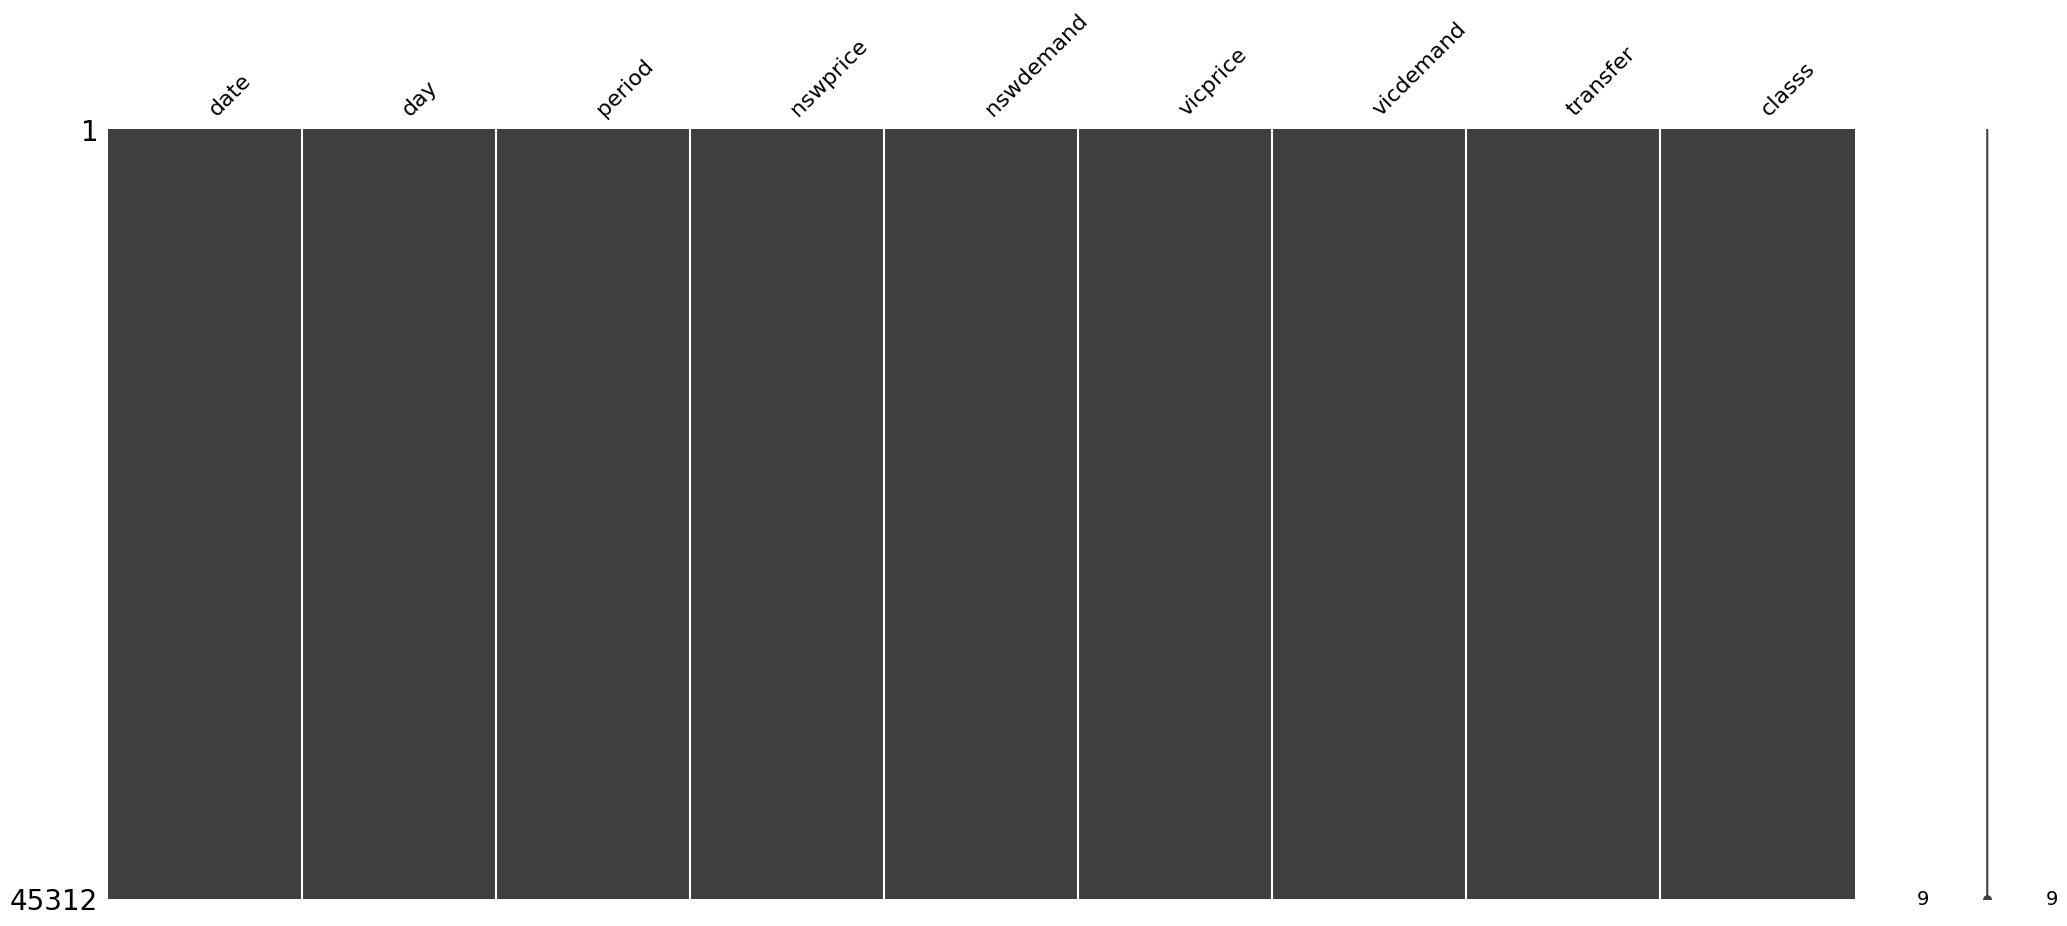

<Figure size 1500x900 with 0 Axes>

In [9]:
msno.matrix(df)
plt.figure(figsize=(15, 9))
plt.show()

No data leaks.

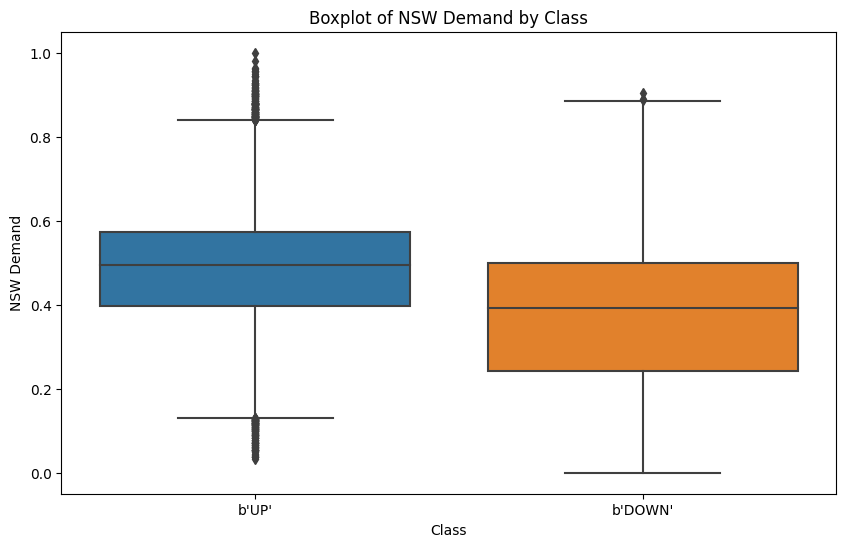

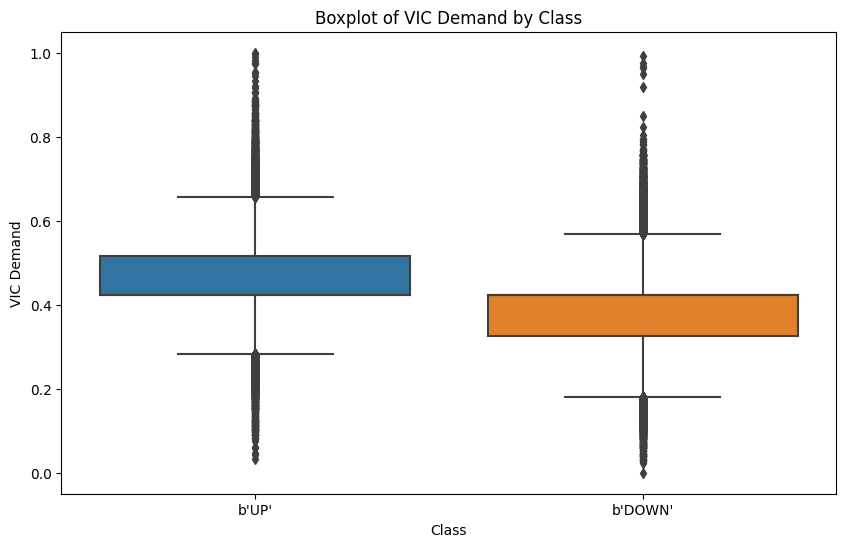

In [10]:
# Boxplot for NSW Demand.
plt.figure(figsize=(10, 6))
sns.boxplot(x='classs', y='nswdemand', data=df)
plt.title('Boxplot of NSW Demand by Class')
plt.xlabel('Class')
plt.ylabel('NSW Demand')
plt.show()

# Boxplot for VIC Demand.
plt.figure(figsize=(10, 6))
sns.boxplot(x='classs', y='vicdemand', data=df)
plt.title('Boxplot of VIC Demand by Class')
plt.xlabel('Class')
plt.ylabel('VIC Demand')
plt.show()

In [11]:
numeric_df = df.select_dtypes(include=[np.number])

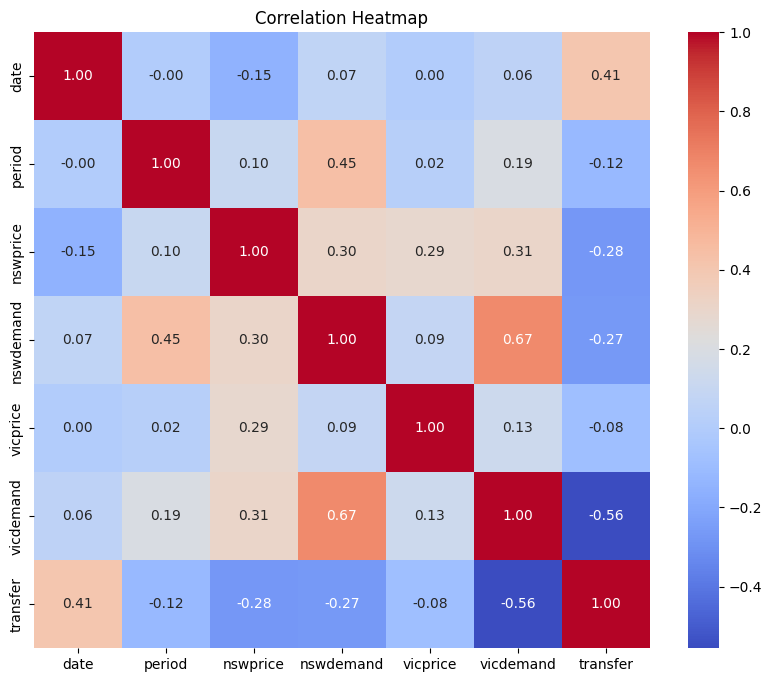

In [12]:
# Correlation matrix.
correlation_matrix = numeric_df.corr()

# Heatmap.
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

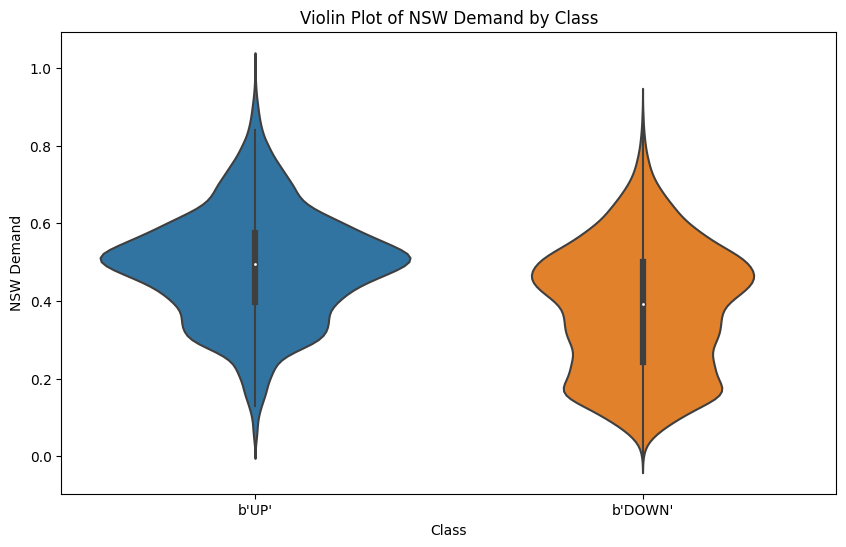

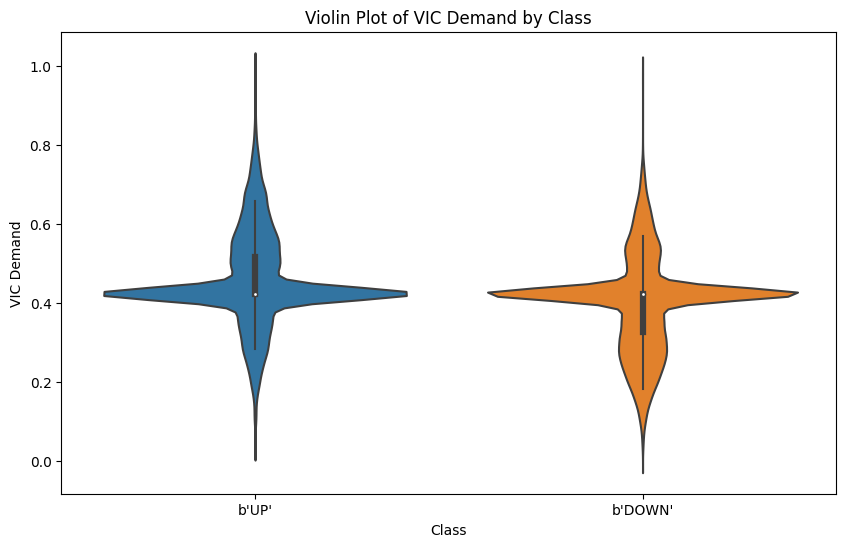

In [13]:
# Violin plot for NSW Demand.
plt.figure(figsize=(10, 6))
sns.violinplot(x='classs', y='nswdemand', data=df)
plt.title('Violin Plot of NSW Demand by Class')
plt.xlabel('Class')
plt.ylabel('NSW Demand')
plt.show()

# Violin plot for VIC Demand.
plt.figure(figsize=(10, 6))
sns.violinplot(x='classs', y='vicdemand', data=df)
plt.title('Violin Plot of VIC Demand by Class')
plt.xlabel('Class')
plt.ylabel('VIC Demand')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


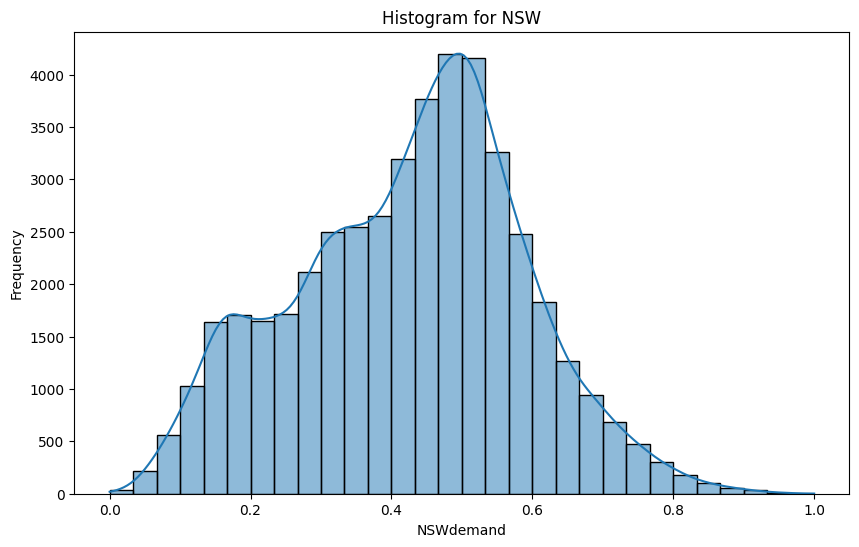

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


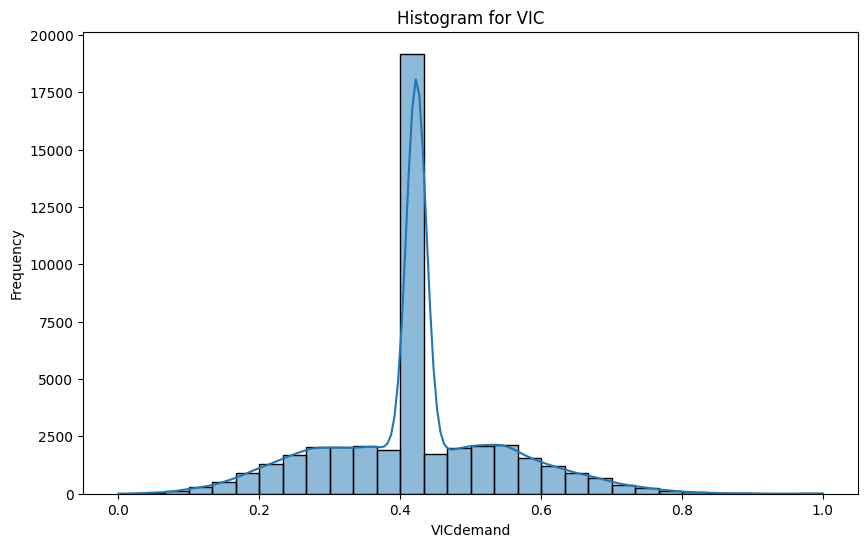

In [14]:
# Histogram for NSW Demand.
plt.figure(figsize=(10, 6))
sns.histplot(df['nswdemand'], bins=30, kde=True)
plt.title('Histogram for NSW')
plt.xlabel('NSWdemand')
plt.ylabel('Frequency')
plt.show()

# Histogram for VIC Demand.
plt.figure(figsize=(10, 6))
sns.histplot(df['vicdemand'], bins=30, kde=True)
plt.title('Histogram for VIC')
plt.xlabel('VICdemand')
plt.ylabel('Frequency')
plt.show()

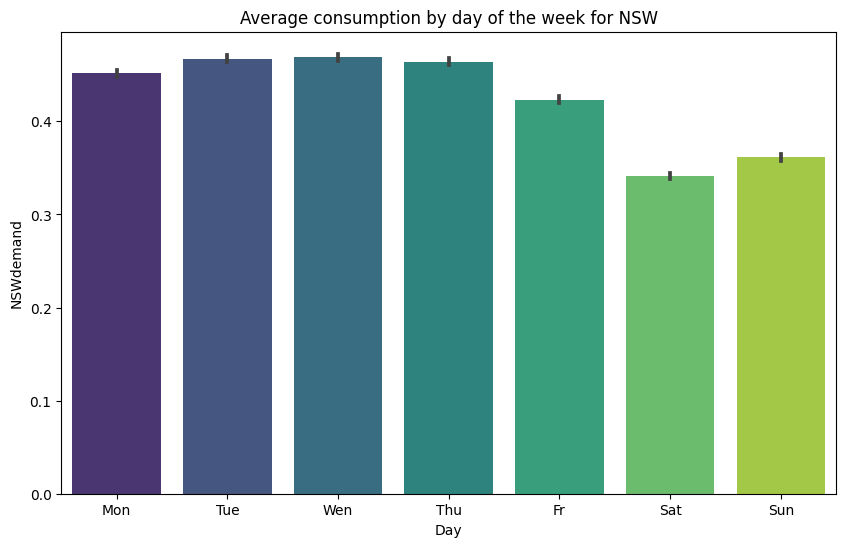

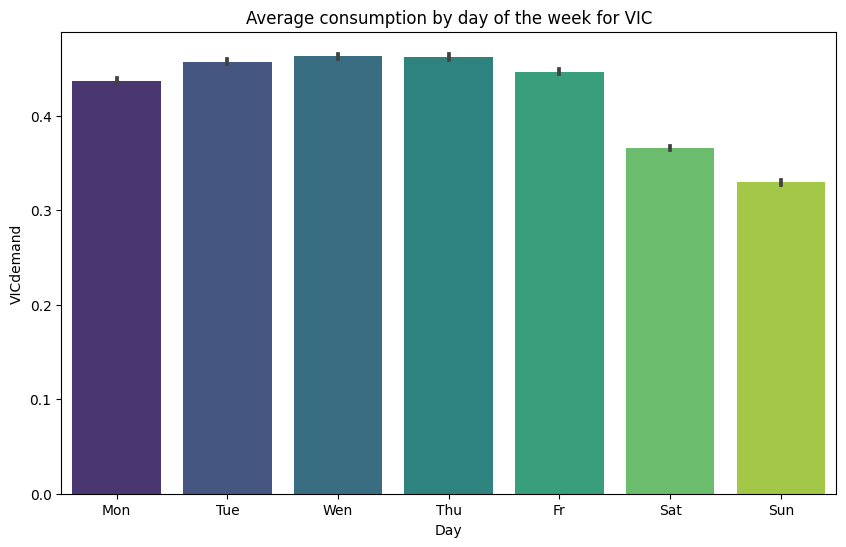

In [15]:
# Barplot for average consumption by day of the week for NSW.
plt.figure(figsize=(10, 6))
sns.barplot(x='day', y='nswdemand', data=df, estimator=np.mean, palette='viridis')
plt.title('Average consumption by day of the week for NSW')
plt.xlabel('Day')
plt.ylabel('NSWdemand')
plt.xticks(ticks=np.arange(7), labels=['Mon', 'Tue', 'Wen', 'Thu', 'Fr', 'Sat', 'Sun'])
plt.show()

# Barplot for average consumption by day of the week for VIC.
plt.figure(figsize=(10, 6))
sns.barplot(x='day', y='vicdemand', data=df, estimator=np.mean, palette='viridis')
plt.title('Average consumption by day of the week for VIC')
plt.xlabel('Day')
plt.ylabel('VICdemand')
plt.xticks(ticks=np.arange(7), labels=['Mon', 'Tue', 'Wen', 'Thu', 'Fr', 'Sat', 'Sun'])
plt.show()

/tmp/ipykernel_79/598897039.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='period', y='nswdemand', data=df, estimator=np.mean, palette='viridis')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


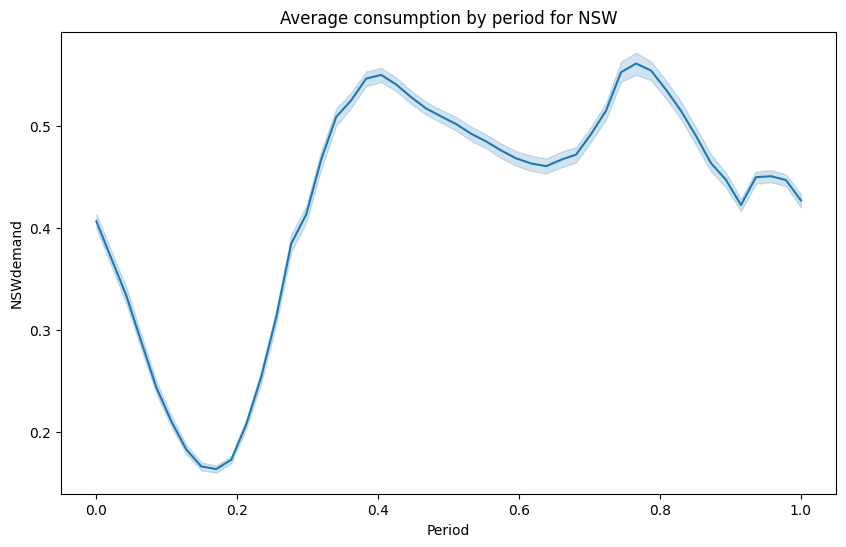

/tmp/ipykernel_79/598897039.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='period', y='vicdemand', data=df, estimator=np.mean, palette=' viridis')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


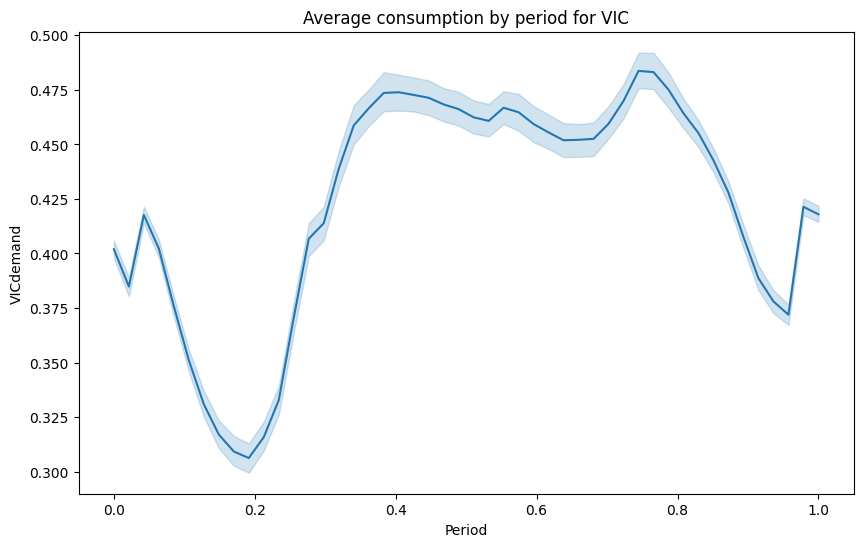

In [16]:
# Line plot for average consumption by time of day for NSW.
plt.figure(figsize=(10, 6))
sns.lineplot(x='period', y='nswdemand', data=df, estimator=np.mean, palette='viridis')
plt.title('Average consumption by period for NSW')
plt.xlabel('Period')
plt.ylabel('NSWdemand')
plt.show()

# Line plot for average consumption by time of day for VIC.
plt.figure(figsize=(10, 6))
sns.lineplot(x='period', y='vicdemand', data=df, estimator=np.mean, palette=' viridis')
plt.title('Average consumption by period for VIC')
plt.xlabel('Period')
plt.ylabel('VICdemand')
plt.show()

Target encoding is needed to indicate the variable that we are trying to predict. In this case, this variable is <span style="color:red">'classs'</span>.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

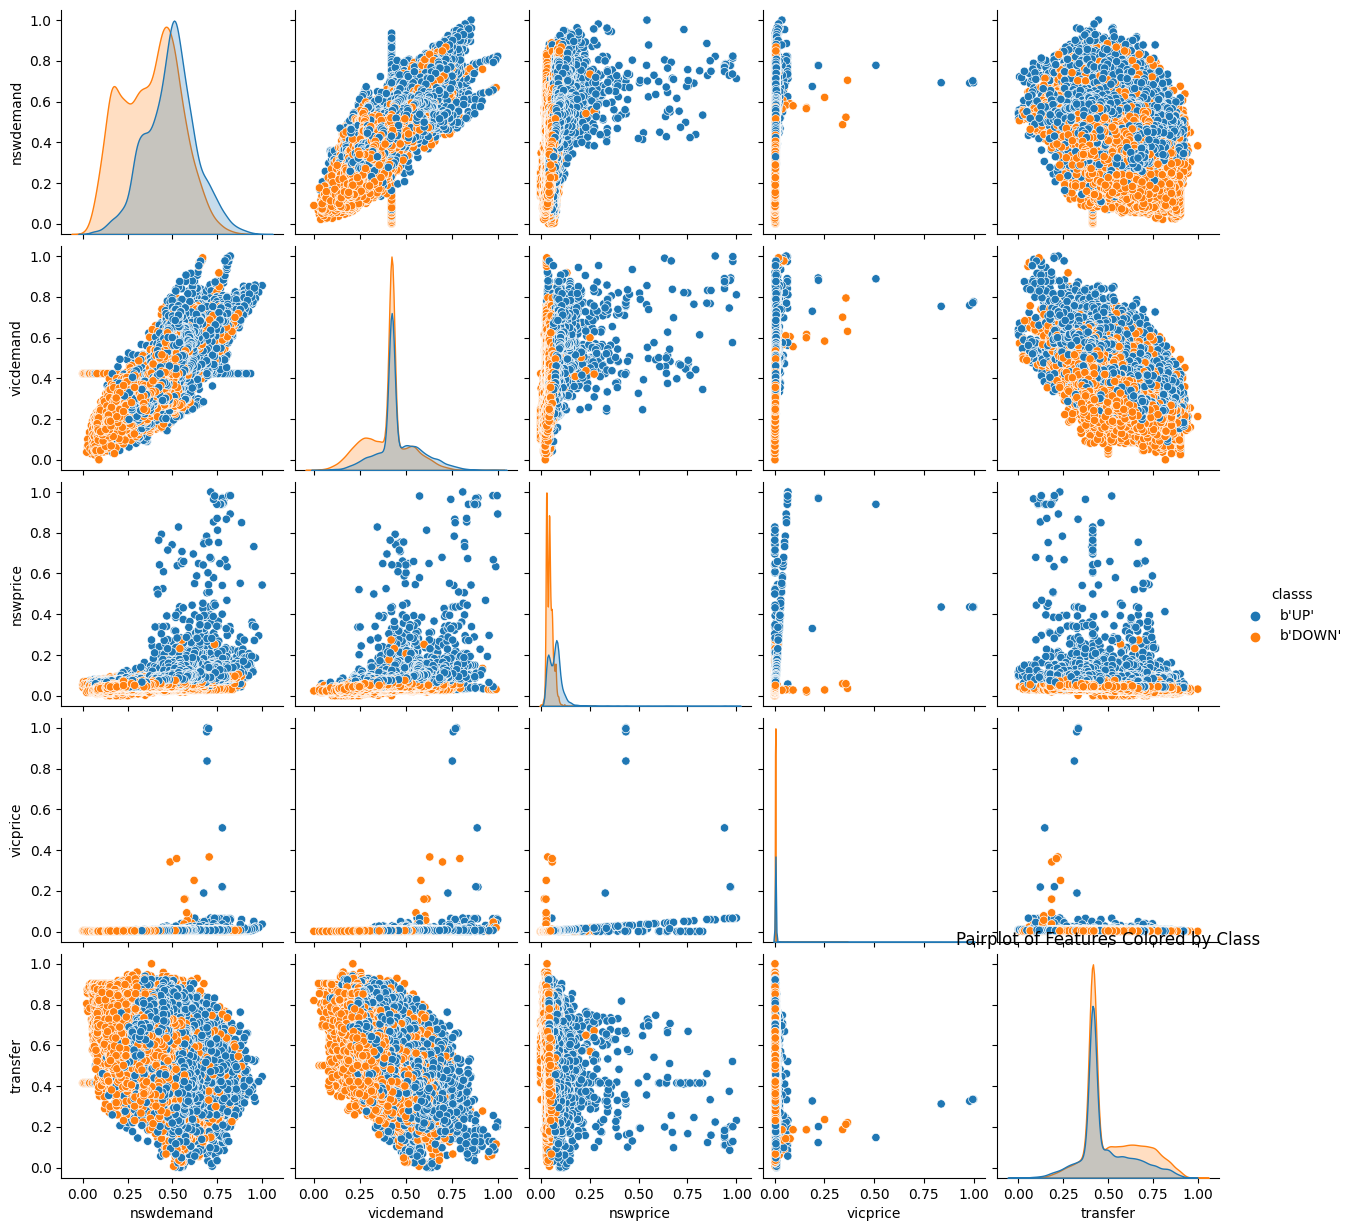

In [17]:
# Create a DataFrame for easier plotting
le = LabelEncoder()
df['classs'] = le.fit_transform(df['classs'])
df_plot = df.copy()
df_plot['classs'] = le.inverse_transform(df_plot['classs'])

# Pairplot
sns.pairplot(df_plot, hue='classs', vars=['nswdemand', 'vicdemand', 'nswprice', 'vicprice', 'transfer'])
plt.title('Pairplot of Features Colored by Class')
plt.show()

#### **<span style="color:blue">Analysis results:</span>**
* **Boxplot and Violin Plot**: These graphs show the distribution of electricity consumption in NSW and VIC by class. This may indicate that price changes (classes) affect electricity demand. There is significantly higher consumption in one class, which indicates that prices were lower during this period, which led to an increase in demand.
* **Correlation Heatmap**: The heat map graph shows how different variables correlate with each other. If the correlation between the variables is close to 1 or -1, this may indicate a strong dependence.
* **Histograms for NSW and VIC**: These graphs show the distribution of electricity consumption. If the distribution has certain peaks, this indicates peak consumption hours.
* **Barplot for average consumption by day of the week**: These graphs show how average electricity consumption varies depending on the day of the week. 
* **Line plot for average consumption by time of day**: These graphs show how electricity consumption varies throughout the day. There is an increase in consumption in the morning and afternoon hours, this indicates a behavior when people use more electricity at these hours.

#### **Data Preparation.**

Convert the date column to datetime format and transform it to epoch timestamps.

In [18]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].apply(lambda x: x.timestamp())

Encode categorical data (e.g., the day column).

In [19]:
df['day'] = le.fit_transform(df['day'])

Separate features (X) and target (y).

In [20]:
X = df[['date', 'day', 'period', 'nswprice', 'nswdemand', 'vicprice', 'vicdemand', 'transfer']].values
y = df['classs'].values

Ensure all feature data is numeric.

In [21]:
X = X.astype('float32')

Split the dataset.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **Solution.**

### **Feature Importance.**

In [23]:
le = LabelEncoder()
df['classs'] = le.fit_transform(df['classs'])
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].apply(lambda x: x.timestamp())

df['day'] = le.fit_transform(df['day'])

X = df[['date', 'day', 'period', 'nswprice', 'nswdemand', 'vicprice', 'vicdemand', 'transfer']]
y = df['classs']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=300, random_state=42)

Feature Scores.

In [24]:
feature_importances = model.feature_importances_
feature_names = X.columns

Scores to DF.

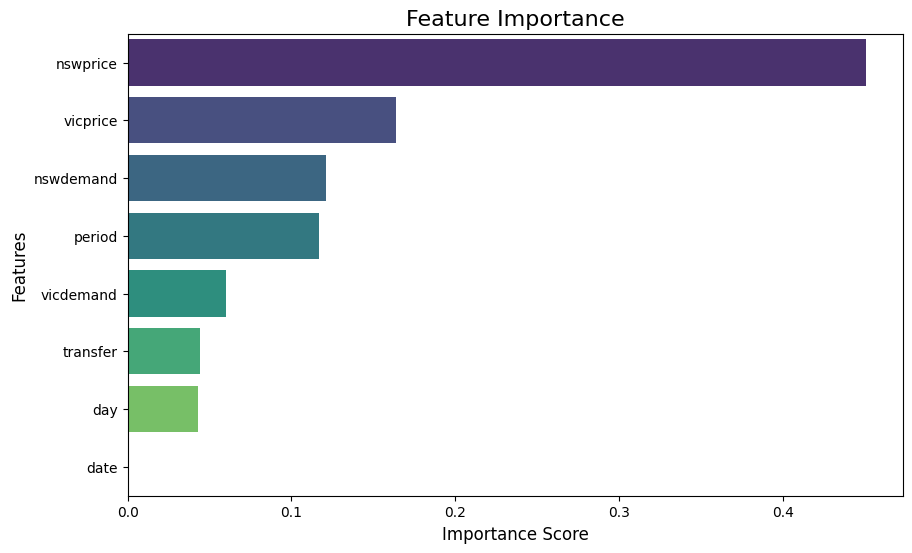

Feature Importances:
     Feature  Importance
3   nswprice    0.450706
5   vicprice    0.164086
4  nswdemand    0.121132
2     period    0.117106
6  vicdemand    0.060183
7   transfer    0.044083
1        day    0.042705
0       date    0.000000


In [25]:
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

print("Feature Importances:")
print(importance_df)

### **Model.**

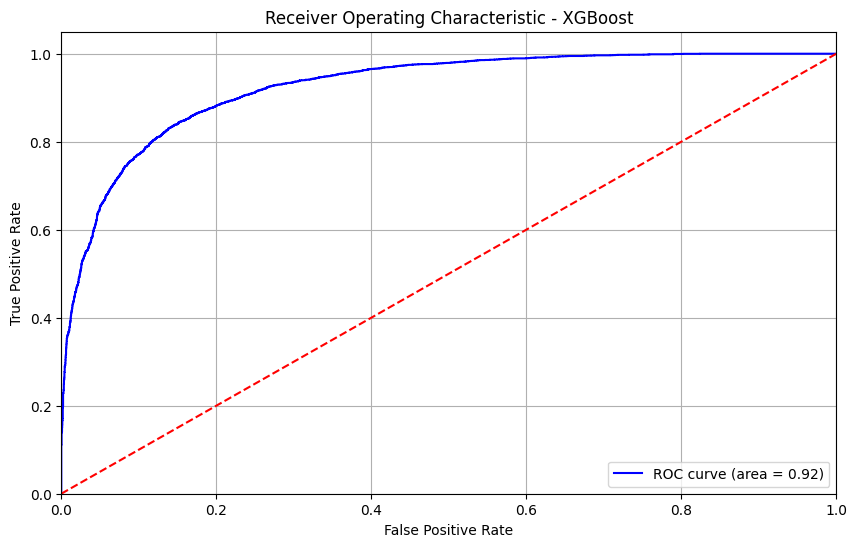


Model Performance Metrics:
      Metric     Score
0   Accuracy  0.847843
1  Precision  0.838263
2     Recall  0.797779
3   F1-Score  0.817520
4        MSE  0.152157
5    Entropy  0.348514


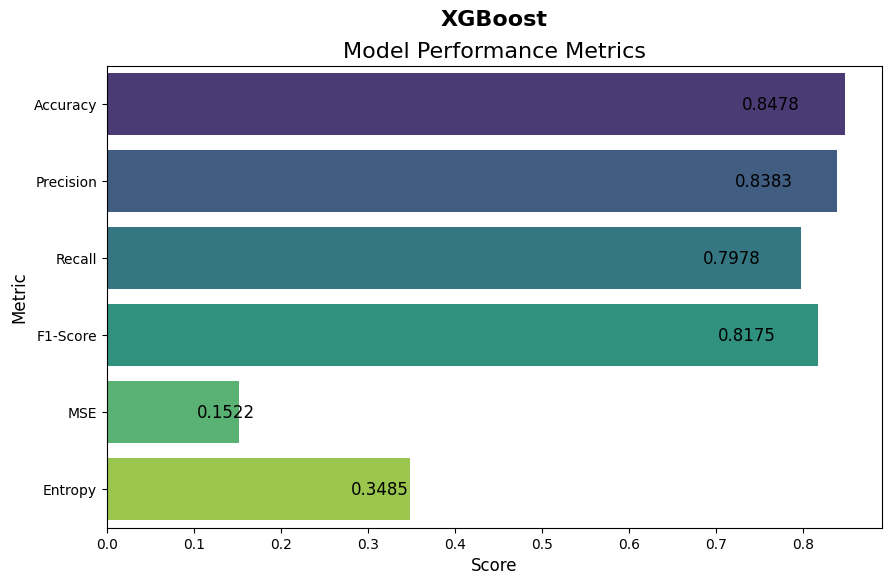

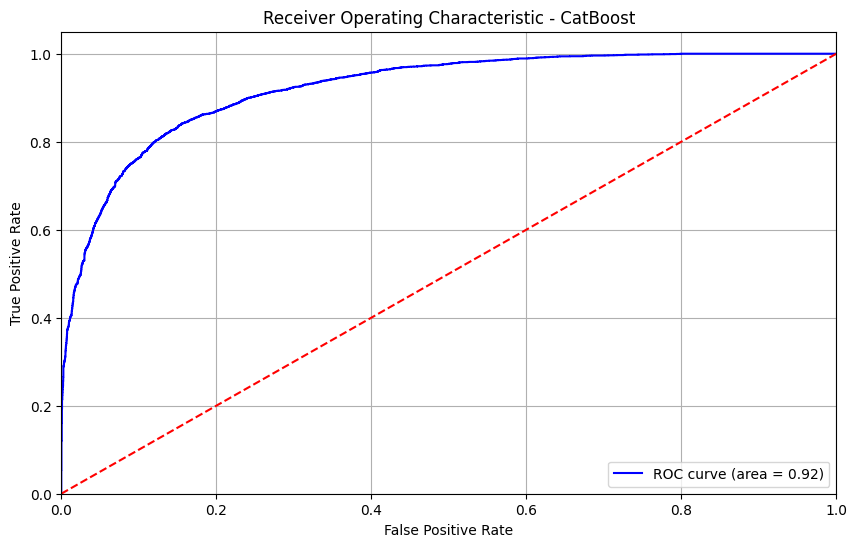


Model Performance Metrics:
      Metric     Score
0   Accuracy  0.844312
1  Precision  0.837401
2     Recall  0.788740
3   F1-Score  0.812342
4        MSE  0.155688
5    Entropy  0.350089


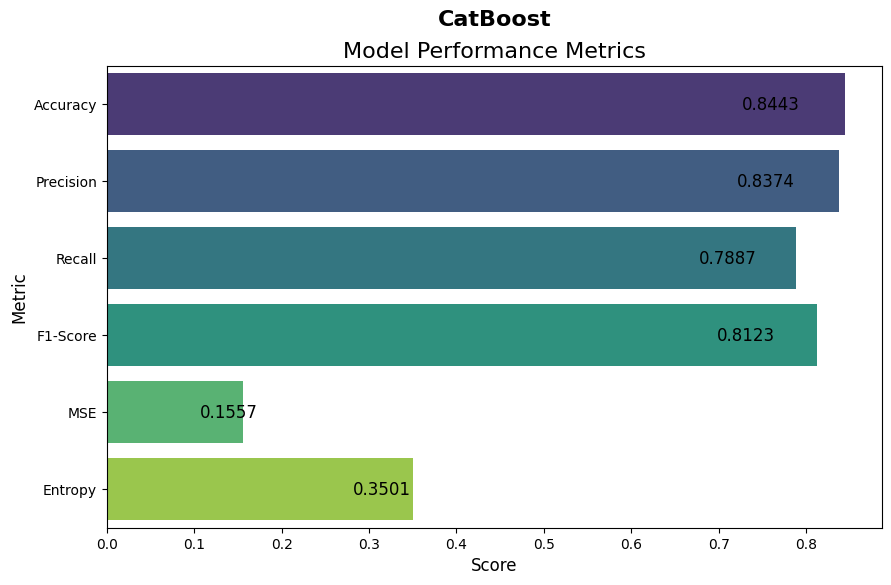

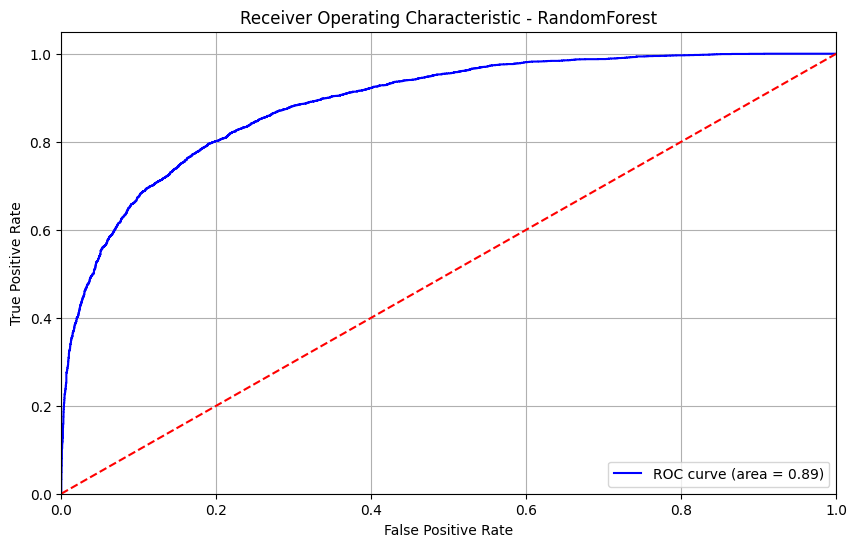


Model Performance Metrics:
      Metric     Score
0   Accuracy  0.805362
1  Precision  0.827126
2     Recall  0.688275
3   F1-Score  0.751339
4        MSE  0.194638
5    Entropy  0.421831


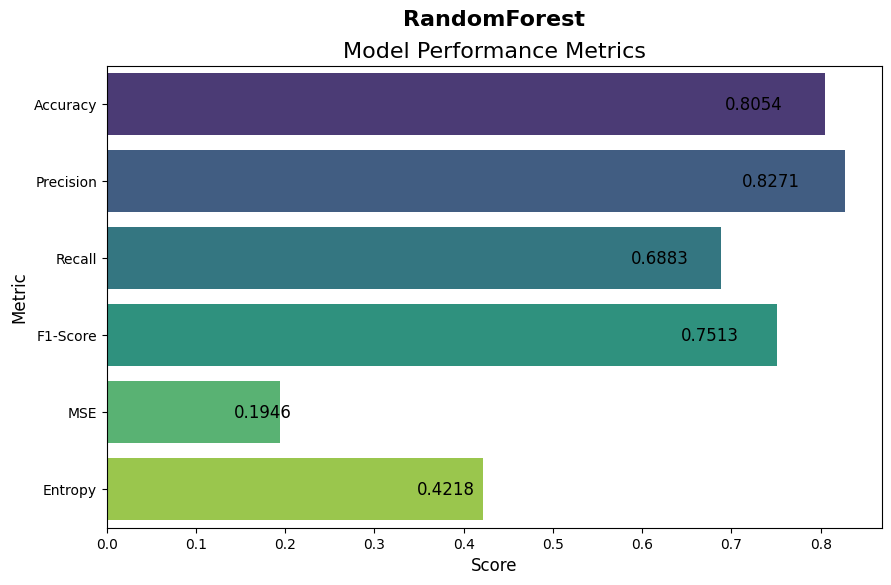

Model Performance Metrics:
              Accuracy  Precision    Recall  F1-Score       MSE   Entropy
XGBoost       0.847843   0.838263  0.797779  0.817520  0.152157  0.348514
CatBoost      0.844312   0.837401  0.788740  0.812342  0.155688  0.350089
RandomForest  0.805362   0.827126  0.688275  0.751339  0.194638  0.421831

Best model by analyzing metrics: XGBoost
Accuracy     0.847843
Precision    0.838263
Recall       0.797779
F1-Score     0.817520
MSE          0.152157
Entropy      0.348514
Score        0.773718
Name: XGBoost, dtype: float64


['model.pkl']

In [26]:
models = {
    # XGBoost.
    'XGBoost': xgb.XGBClassifier(
        n_estimators=4000,  # Increased number of trees to improve the quality of the model.
        learning_rate=0.04,  # The low learning rate allows the model to update weights more carefully, which helps to avoid overfitting.
        objective='binary:logistic',  # Indicates that the task is a binary classification.
        eval_metric='logloss',  # Logarithmic loss is a standard metric for evaluating the quality of binary classification.
        use_label_encoder=False,  # Disabling the outdated label encoding method to prevent warnings.
        verbosity=1  # The output level of information about the learning process, 1 allows to see progress.
    ),
    
    # CatBoost.
    'CatBoost': CatBoostClassifier(
        iterations=4000,  # High number of iterations for deep learning on complex data.
        learning_rate=0.04,  
        objective='Logloss',  # Using logarithmic loss for binary classification.
        eval_metric='AUC',  # The area under the ROC curve (AUC) is a good metric for assessing the quality of classification.
        task_type='CPU',  # Indicates that the model will be trained on the CPU, which is important for compatibility with available resources.
        verbose=0 
    ),
    
    # RandomForest.
    'RandomForest': RandomForestClassifier(
        n_estimators=300,  # The number of trees in the forest, 300 is a reasonable value for good quality without excessive training time.
        max_depth=10,  # Limiting the depth of trees to prevent overfitting, allowing trees to be deep enough to capture complex dependencies.
        random_state=42  # Setting a fixed state of the random number generator for reproducibility of results.
    )
}

# param_grid_xgb = {
#     'n_estimators': [100, 200, 300, 4000],
#     'learning_rate': [0.01, 0.04, 0.1],
#     'max_depth': [3, 5, 10],
# }

# param_grid_cat = {
#     'iterations': [100, 200, 4000],
#     'learning_rate': [0.01, 0.04, 0.1],
#     'depth': [3, 5, 10],
# }

# param_grid_rf = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20],
# }

# xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, verbosity=1)
# cat_model = CatBoostClassifier(task_type='CPU', verbose=0)
# rf_model = RandomForestClassifier(random_state=42)

# Grid Search для XGBoost
# grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, scoring='f1', cv=3, verbose=1, n_jobs=-1)
# grid_search_xgb.fit(X_train, y_train)
# best_xgb = grid_search_xgb.best_estimator_

# Grid Search для CatBoost
# grid_search_cat = GridSearchCV(estimator=cat_model, param_grid=param_grid_cat, scoring='f1', cv=3, verbose=1, n_jobs=-1)
# grid_search_cat.fit(X_train, y_train)
# best_cat = grid_search_cat.best_estimator_

# Grid Search для RandomForest
# grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, scoring='f1', cv=3, verbose=1, n_jobs=-1)
# grid_search_rf.fit(X_train, y_train)
# best_rf = grid_search_rf.best_estimator_

# best_models = {
#     'XGBoost': best_xgb,
#     'CatBoost': best_cat,
#     'RandomForest': best_rf
# }

results = {}

# Models training.
for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions_proba = model.predict_proba(X_test)[:, 1]
    predictions = (predictions_proba > 0.5).astype(int)
    
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    entropy = log_loss(y_test, predictions_proba)

    # Results saving.
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'MSE': mse,
        'Entropy': entropy
    }

    # ROC AUC
    fpr, tpr, _ = roc_curve(y_test, predictions_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
    
    metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'MSE', 'Entropy'],
    'Score': [accuracy, precision, recall, f1, mse, entropy]
    }
    df_metrics = pd.DataFrame(metrics)
    
    print("\nModel Performance Metrics:")
    print(df_metrics)
    
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Score', y='Metric', data=df_metrics, palette='viridis')
    plt.title('Model Performance Metrics', fontsize=16)
    plt.xlabel('Score', fontsize=12)
    plt.ylabel('Metric', fontsize=12)

    plt.text(0.5, 1.1, model_name, ha='center', va='center', fontsize=16, fontweight='bold', transform=ax.transAxes)
    
    for p in ax.patches:
        ax.annotate(f'{p.get_width():.4f}', 
                    (p.get_x() + p.get_width() * 0.9, p.get_y() + p.get_height() / 2),
                    ha='center', va='center', fontsize=12, color='black')
    plt.show()

results_df = pd.DataFrame(results).T
print("Model Performance Metrics:")
print(results_df)

weights = {
    'Accuracy': 0.2,
    'Precision': 0.2,
    'Recall': 0.2,
    'F1-Score': 0.4,  
    'MSE': -0.1,      
    'Entropy': -0.1   
}

results_df['Score'] = (
    results_df['Accuracy'] * weights['Accuracy'] +
    results_df['Precision'] * weights['Precision'] +
    results_df['Recall'] * weights['Recall'] +
    results_df['F1-Score'] * weights['F1-Score'] +
    results_df['MSE'] * weights['MSE'] +
    results_df['Entropy'] * weights['Entropy']
)

best_model_name = results_df['Score'].idxmax()
best_model_metrics = results_df.loc[best_model_name]

# print("\nBest Hyperparameters for Each Model:")
# print("XGBoost:", grid_search_xgb.best_params_)
# print("CatBoost:", grid_search_cat.best_params_)
# print("RandomForest:", grid_search_rf.best_params_)

print(f"\nBest model by analyzing metrics: {best_model_name}")
print(best_model_metrics)

# Best model saving.
best_model = models[best_model_name]
joblib.dump(best_model, 'model.pkl')